# CSC413 Project: Toxicity Detector

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import DataLoader, TensorDataset

## Data

We will begin by downloading the data onto Google Colab from kaggle. The data is retrieved from https://www.kaggle.com/datasets/fizzbuzz/cleaned-toxic-comments

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload() # Upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seoulsim","key":"aeaf258f72132ae51232c7d3f11ecab3"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d fizzbuzz/cleaned-toxic-comments
! unzip cleaned-toxic-comments.zip

 94% 41.0M/43.7M [00:02<00:00, 23.3MB/s]
100% 43.7M/43.7M [00:02<00:00, 20.6MB/s]
Archive:  cleaned-toxic-comments.zip
  inflating: test_preprocessed.csv   
  inflating: train_preprocessed.csv  


## Data Analysis and Processing
We will analyze the type and amount of data that we will work with and introduce a validation set.

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/train_preprocessed.csv')
df_test = pd.read_csv('/content/test_preprocessed.csv')

# Randomly split the train set into a 15% validation and 85% train set
df_val = df_train.sample(n=int(len(df_train) * 0.15))
df_train = df_train.drop(df_val.index)

# First few samples in the data set of each toxicity level
print(df_train.head())
print(df_train[df_train['toxic']==1.0].head())
print(df_train[df_train['threat']==1.0].head())
print(df_train[df_train['severe_toxic']==1.0].head())

                                        comment_text                id  \
0  explanation why the edits made under my userna...  0000997932d777bf   
1  d aww  he matches this background colour i m s...  000103f0d9cfb60f   
3    more i can t make any real suggestions on im...  0001b41b1c6bb37e   
4  you  sir  are my hero  any chance you remember...  0001d958c54c6e35   
5   congratulations from me as well  use the tool...  00025465d4725e87   

   identity_hate  insult  obscene    set  severe_toxic  threat  toxic  \
0            0.0     0.0      0.0  train           0.0     0.0    0.0   
1            0.0     0.0      0.0  train           0.0     0.0    0.0   
3            0.0     0.0      0.0  train           0.0     0.0    0.0   
4            0.0     0.0      0.0  train           0.0     0.0    0.0   
5            0.0     0.0      0.0  train           0.0     0.0    0.0   

   toxicity  
0       0.0  
1       0.0  
3       0.0  
4       0.0  
5       0.0  
                                

In [ ]:
training_samples = len(df_train)
val_samples = len(df_val)
testing_samples = len(df_test)
print(f'Train samples: {training_samples}')
print(f'Validation samples: {val_samples}')
print(f'Test samples: {testing_samples}')

Train samples: 135636
Validation samples: 23935
Test samples: 153164


Now we will tokenize and prepare the word embedding:

In [ ]:
def tokenize_text(text):
    # Check if text is not NaN
    if isinstance(text, str):
        return text.split()
    else:
        return []

def convert_indices(data, vocab):
    result = []
    for row in data:
        text = row.comment_text
        label = row.toxicity
        words = tokenize_text(text)
        indices = [vocab[word] for word in words if word in vocab]
        result.append((indices, label))
    return result

Create vocab:

In [ ]:
vocab = {}
for text in df_train['comment_text']:
    words = tokenize_text(text)
    for word in words:
        if word not in vocab:
            vocab[word] = len(vocab)
print(vocab)

# Convert data to word indices
train_data_indices = convert_indices(df_train.itertuples(index=False), vocab)
val_data_indices = convert_indices(df_val.itertuples(index=False), vocab)
test_data_indices = convert_indices(df_test.itertuples(index=False), vocab)

max_seq_length = 200
pad_sequence = nn.utils.rnn.pad_sequence

{'explanation': 0, 'why': 1, 'the': 2, 'edits': 3, 'made': 4, 'under': 5, 'my': 6, 'username': 7, 'hardcore': 8, 'metallica': 9, 'fan': 10, 'were': 11, 'reverted': 12, 'they': 13, 'weren': 14, 't': 15, 'vandalisms': 16, 'just': 17, 'closure': 18, 'on': 19, 'some': 20, 'gas': 21, 'after': 22, 'i': 23, 'voted': 24, 'at': 25, 'new': 26, 'york': 27, 'dolls': 28, 'fac': 29, 'and': 30, 'please': 31, 'don': 32, 'remove': 33, 'template': 34, 'from': 35, 'talk': 36, 'page': 37, 'since': 38, 'm': 39, 'retired': 40, 'now': 41, 'd': 42, 'aww': 43, 'he': 44, 'matches': 45, 'this': 46, 'background': 47, 'colour': 48, 'seemingly': 49, 'stuck': 50, 'with': 51, 'thanks': 52, 'january': 53, 'utc': 54, 'more': 55, 'can': 56, 'make': 57, 'any': 58, 'real': 59, 'suggestions': 60, 'improvement': 61, 'wondered': 62, 'if': 63, 'section': 64, 'statistics': 65, 'should': 66, 'be': 67, 'later': 68, 'or': 69, 'a': 70, 'subsection': 71, 'of': 72, 'types': 73, 'accidents': 74, 'think': 75, 'references': 76, 'may': 

In [ ]:
# The following code proves that the longest sequences are super long.
# this longest sequence will define the rest of the shapes, as
# pad_sequence pads with 0s, to the length of the longest sequence.

lengths = [len(item[0]) for item in val_data_indices]

# Sort indices based on lengths
sorted_indices = sorted(enumerate(lengths), key=lambda x: x[1], reverse=True)

# Extract the indices of the top 3 longest sequences
top3_indices = [val_data_indices[i[0]] for i in sorted_indices[:3]]

# Print the lengths of the top 3 longest sequences
print("Top 3 longest sequences:")
for indices, label in top3_indices:
    print(f"Length: {len(indices)}, Label: {label}")


# Pad sequences to a common length
train_indices_padded = pad_sequence([torch.tensor(item[0]) for item in train_data_indices], batch_first=True)
val_indices_padded = pad_sequence([torch.tensor(item[0]) for item in val_data_indices], batch_first=True)
test_indices_padded = pad_sequence([torch.tensor(item[0]) for item in test_data_indices], batch_first=True)
print(val_indices_padded.shape)
def print_indices_in_sequence(sequence):
    for index in sequence[0]:
        print(index.item())

print_indices_in_sequence(val_indices_padded)

# Convert labels to tensors
train_labels = torch.tensor([item[1] for item in train_data_indices])
val_labels = torch.tensor([item[1] for item in val_data_indices])
test_labels = torch.tensor([item[1] for item in test_data_indices])

def print_label_counts(labels):
    unique_labels, label_counts = torch.unique(labels, return_counts=True)

    print("Label Counts:")
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {int(label)}: {count} samples")

print_label_counts(val_labels)

Top 3 longest sequences:
Length: 1354, Label: 3.0
Length: 1112, Label: 4.0
Length: 1032, Label: 4.0
torch.Size([23935, 1354])
9367
23
75
97
78
104
656
81
25
2
344
121
2203
3783
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [ ]:

# Create TensorDataset
train_dataset = TensorDataset(train_indices_padded, train_labels)val_dataset = TensorDataset(val_indices_padded, val_labels)
test_dataset = TensorDataset(test_indices_padded, test_labels)
print("Validation Dataset:")
print("Number of Samples:", len(val_dataset))
print("Shape Example:", val_dataset[0][0])
print("Label Example:", val_dataset[0][1])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

class LSTMToxicityModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMToxicityModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        lstm_out, _ = self.lstm(embedded)
        last_hidden_state = lstm_out[:, -1, :]
        output = self.fc(last_hidden_state)
        return output

Validation Dataset:
Number of Samples: 23935
Shape Example: tensor([9367,   23,   75,  ...,    0,    0,    0])
Label Example: tensor(0.)


torch.Size([135636, 1558])
torch.Size([135636])


ValueError: ignored

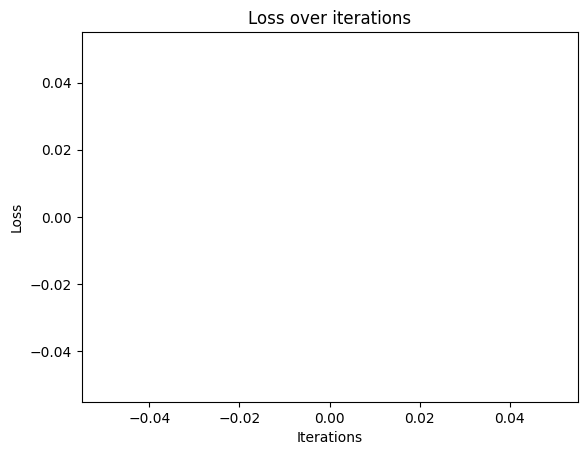

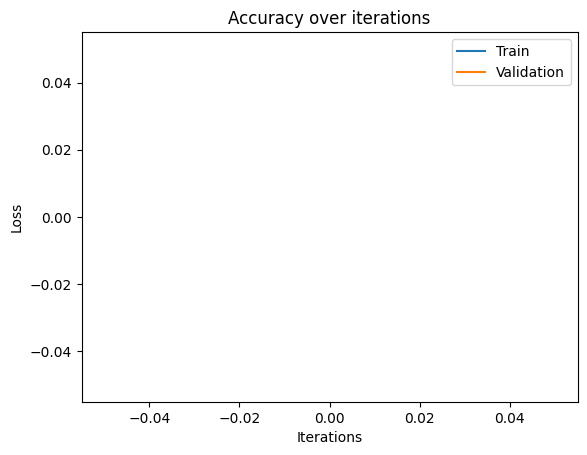

In [ ]:
# Training code

#NOTES: for some reason the test data goes

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for i in batch:
        print(i.shape)
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        # TODO: what do we need to do with `label`?
        label_list.append(torch.tensor(label))
    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t


def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total


def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                              #  collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts) # TODO
                loss = criterion(z, labels) # TODO
                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])
print(train_dataset[:][0].shape)
print(train_dataset[:][1].shape)
model = LSTMToxicityModel(vocab_size = len(vocab), embedding_dim = 100, hidden_size = 64, num_classes = 2)
train_model(model, train_dataset[:20], val_dataset[:20], batch_size=1, num_epochs=10, plot_every=20)
